# Modeling
This modeling script shows all the steps taken to model the data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from src.static import DATA_DIR
%matplotlib inline

In [2]:
# Load Data
df = pd.read_csv(f'{DATA_DIR}/preprocessed_data.csv')

## Train Test Split
The next step will split our data into training, validation, and testing sets. To mimic real world contidions our model will train on the earlier years of the data and use the newer years as validation and testing sets. 

In [3]:
df.year.value_counts().sort_index().cumsum()

year
2019     7284
2020    15295
2021    22764
2022    29742
2023    34268
Name: count, dtype: int64

In [4]:
print(f'Training records from 2021 and before make up {round((22764 * 100) / df.shape[0], 2)}% of the data.')

Training records from 2021 and before make up 66.43% of the data.


In [5]:
print(f'Validation & Testing records from 2022 make up {round(((df.shape[0] - 22764)* 100) / df.shape[0], 2)}% of the data.')

Validation & Testing records from 2022 make up 33.57% of the data.


Our target variable is the `num_affordable_units` column. This information is derived from the `affordability_levels` columns, so in order to prevent data leaks these columns cannot be provided to the model. They will be removed here.

In [6]:
df = df[[x for x in df.columns if not x.startswith('affordability')]].set_index('record_number')

The next step is to split off the training variables and prepare the validation and test sets.

In [7]:
X_train, X, y_train, y = (df[df.year <= 2021].drop(['num_affordable_units'], axis=1),
               df[df.year > 2021].drop(['num_affordable_units'], axis=1),
               df[df.year <= 2021].num_affordable_units,
               df[df.year > 2021].num_affordable_units)

We will scale the X variables by standard deviation using Sklearn's standard scaler. Consistent varaible sizing improves performance on most models.

In [8]:
# instantiate scaler obj
scaler = StandardScaler()

# fit only to training data
scaler.fit(X_train)

# transform X sets
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

Now that everything has been scaled we will continue to split out the testing and validation sets. We will use Sklearn's train_test_split, and we will split the non-training data from 2022 and 2023 into a 50% 50% split, stratified by year. The stratification on the year variable will assue that the distribution of records from one year to the next will stay consistent between the two otherwise randomly selected datasets.

In [9]:
# train test split
X_val_scaled, X_test_scaled, y_val, y_test = train_test_split(
    X_scaled, y, test_size = 0.5, stratify=X['year'], random_state=42
    )

# Linear Regression
Now we will attempt a simple linear regression analysis using our training and validation sets to see what our baseline performance will be. More complex models will be attempted afterwards

In [10]:
# instantiate LinearRegression object
model = LinearRegression()

# fit training data
model.fit(X_train_scaled, y_train)

# make predictions
y_pred = model.predict(X_val_scaled)

# gather performance metrics
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# print report
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 290.5813512844896
R-squared Score: 0.8734879614297506


In [11]:
# observe model coefficients
{k:v for k,v in zip(model.feature_names_in_, model.coef_)}

{'year': -0.885870998337117,
 'num_units': -58490402501992.1,
 'num_bedrooms_0-1': 31659680918494.86,
 'num_bedrooms_>=2': 35463355377153.7,
 'enterprise_flag_freddie': -1.486328125,
 'census_tract_2020_>=10%, <30%': -1.1165771484375,
 'census_tract_2020_>=30% <100%': -1.991455078125,
 'tract_income_ratio_>10, <=120%': -2.418701171875,
 'tract_income_ratio_>120%': -3.790283203125,
 'date_of_mortgage_note_same year as acquired': -0.660400390625,
 'purpose_of_loan_new build': -0.283935546875,
 'purpose_of_loan_purchase': -6.41845703125,
 'purpose_of_loan_refinance': -6.818603515625,
 'type_of_seller_SAIF or BIF': -0.5455322265625,
 'type_of_seller_mortgage_company': -1.03546142578125,
 'federal_guarantee_no': 0.09375,
 'federal_guarantee_yes': -1.0986328125,
 'tot_num_units_25-50': -0.3228759765625,
 'tot_num_units_5-24': -0.4794921875,
 'tot_num_units_51-99': -0.061767578125,
 'tot_num_units_> 149': -2.33544921875,
 'after_covid_ind': 0.9453125}

The massive coefficients on the naive linear regression indicate that there is multicolinearity throwing off our coefficient sizing. We can will use regularization and feature selection techinques to mitigate these issues

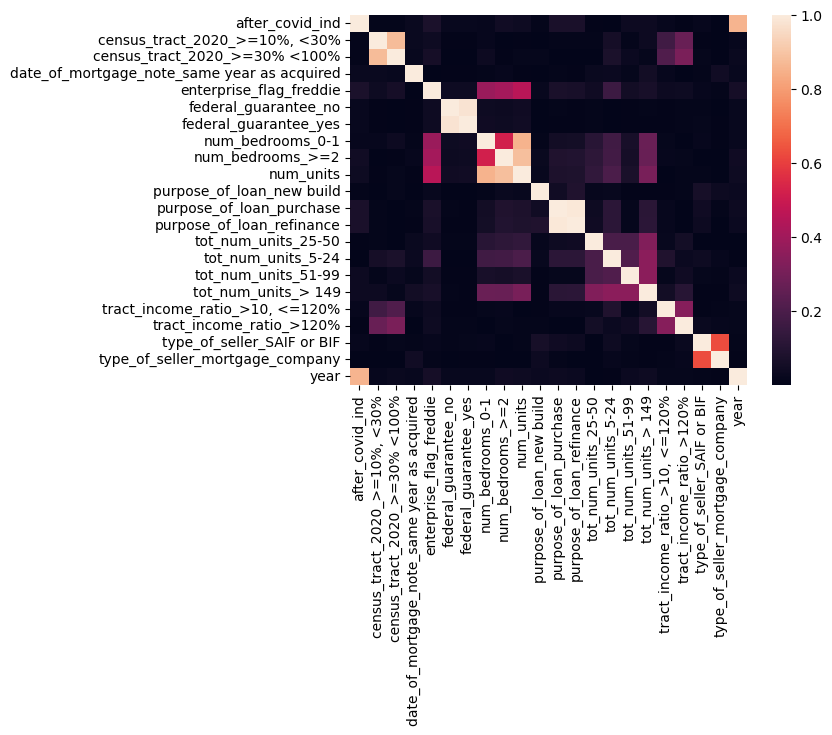

In [12]:
# plot correlation heatmap
sns.heatmap(X_train_scaled[sorted(X_train_scaled.columns)].corr().apply(abs));

In [13]:
X_scaled[[x for x in X_scaled.columns if x.startswith('num_bed')]].corr()

,num_bedrooms_0-1,num_bedrooms_>=2
num_bedrooms_0-1,1.000000,0.504312
num_bedrooms_>=2,0.504312,1.000000


Predictably, there are some pockets of multicolinearity, particularly residing between one-hot-encoded categorical columns which we created during feature engineering. The example above can be mitigated by removing one of the one hot encoded features

In [14]:
X_train_scaled.drop('num_bedrooms_0-1', axis=1, inplace=True)
X_val_scaled.drop('num_bedrooms_0-1', axis=1, inplace=True)
X_test_scaled.drop('num_bedrooms_0-1', axis=1, inplace=True)


## Recursive Feature Elimination
Recursive feature elimination iteratively tests different combinations of feature variables at a given n to determine the optimal combination of features for the given model

In [15]:
# Set up RFE
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
rfe = rfe.fit(X_train_scaled, y_train)

# Show selected features
cols = rfe.feature_names_in_[rfe.support_]
cols

array(['num_units', 'num_bedrooms_>=2', 'enterprise_flag_freddie',
       'census_tract_2020_>=30% <100%', 'tract_income_ratio_>10, <=120%',
       'tract_income_ratio_>120%', 'purpose_of_loan_purchase',
       'purpose_of_loan_refinance', 'federal_guarantee_yes',
       'tot_num_units_> 149'], dtype=object)

### Re-test with reduced feature set

In [16]:
# instantiate LinearRegression object
model = LinearRegression()

# fit training data
model.fit(X_train_scaled[cols], y_train)

# make predictions
y_pred = model.predict(X_val_scaled[cols])

# gather performance metrics
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# print report
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 280.26528721011954
R-squared Score: 0.8779793243141917


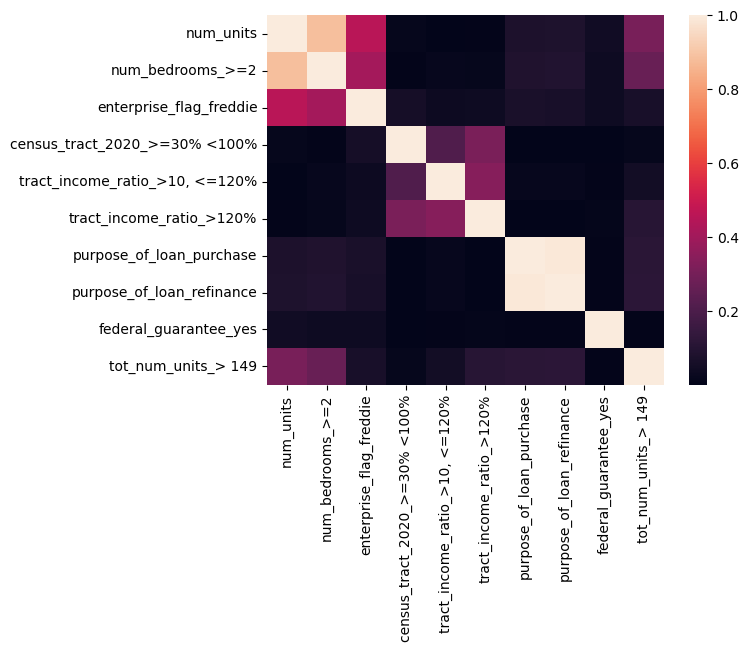

In [17]:
# plot correlation heatmap
sns.heatmap(X_train_scaled[cols].corr().apply(abs));

Using RFE has removed 21 extrenous features at little to no cost of performance on validation. RFE will be a useful component of model selection moving forward

# Lasso Regression
Lasso regression uses L1 regularization which penalizes coeficients on variables to reduce variance and increase bias. Lasso regularization also has the added beneifit of potentially reducing features down event further since the shrinking factor on variable coefficients can go all the way to zero. The regularization parameter alpha can be set to a number that increases or reduces the strength of the regularization. We can iteratively test multiple values for this using a grid search which will fit and test models at different values for alpha

In [18]:
# define search parameters
param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]
}

# perform search for best value
grid_search = GridSearchCV(estimator=Lasso(), param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

In [19]:
# Set up RFE
rfe = RFE(estimator=best_model, n_features_to_select=10)
rfe = rfe.fit(X_train_scaled, y_train)

# Show selected features
cols = rfe.feature_names_in_[rfe.support_]

# instantiate LinearRegression object
model = best_model

# fit training data
model.fit(X_train_scaled[cols], y_train)

# make predictions
y_pred = model.predict(X_val_scaled[cols])

# gather performance metrics
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# print report
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 277.7366506716956
R-squared Score: 0.8790802310374385


Lasso regression seems to perform marginally better than the unregularized model by reducing the mean squared error slightly. 

In [20]:
model

Lasso(alpha=0.1)

An alpha value of 0.1 is selected for the regularization parameter. The following coefficients are used:

In [21]:
{k:v for k,v in zip(model.feature_names_in_, model.coef_)}

{'num_units': 46.241334958417845,
 'num_bedrooms_>=2': 3.334330657782958,
 'enterprise_flag_freddie': -1.3977471026941106,
 'census_tract_2020_>=30% <100%': -0.7902675957707452,
 'tract_income_ratio_>10, <=120%': -2.125419990586458,
 'tract_income_ratio_>120%': -3.5290619366461606,
 'date_of_mortgage_note_same year as acquired': -0.5367203795095581,
 'type_of_seller_mortgage_company': -0.6120784459334085,
 'federal_guarantee_yes': -1.0944064637430064,
 'tot_num_units_> 149': -1.9289237359617557}

# Ridge Regression
Ridge regressionuses L2 regularization which also penalizes the coefficients but does not remove features entirely. It is performed via a different mathematical calculation, lets assess it's performance.

In [22]:
# define search parameters
param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]
}

# perform search for best value
grid_search = GridSearchCV(estimator=Ridge(), param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

# Set up RFE
rfe = RFE(estimator=best_model, n_features_to_select=10)
rfe = rfe.fit(X_train_scaled, y_train)

# Show selected features
cols = rfe.feature_names_in_[rfe.support_]

# instantiate LinearRegression object
model = best_model

# fit training data
model.fit(X_train_scaled[cols], y_train)

# make predictions
y_pred = model.predict(X_val_scaled[cols])

# gather performance metrics
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# print report
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 280.27465000009533
R-squared Score: 0.8779752479836174


Ridge regression performs marginally worse than Lasso regression. Let's examine the the coefficients

In [23]:
{k:v for k,v in zip(model.feature_names_in_, model.coef_)}

{'num_units': 46.477394629378715,
 'num_bedrooms_>=2': 3.3245518905530234,
 'enterprise_flag_freddie': -1.6299666296122537,
 'census_tract_2020_>=30% <100%': -0.9774972909940423,
 'tract_income_ratio_>10, <=120%': -2.346336637192719,
 'tract_income_ratio_>120%': -3.7399403762784855,
 'purpose_of_loan_purchase': -4.429455271524257,
 'purpose_of_loan_refinance': -4.84402431557667,
 'federal_guarantee_yes': -1.1947191339541117,
 'tot_num_units_> 149': -2.1626984085866474}

This model swaps out some features but ultimately achieves marginally worse results

# Elastic Net
Elastic net combines the strengths of both Lasso and Ridge regression by mixing the two regularization parameters together. 

In [24]:
# define search parameters
param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0],
    'l1_ratio': [0, 0.2, 0.4, 0.6, 0.8, 1]
}

# perform search for best value
grid_search = GridSearchCV(estimator=ElasticNet(random_state=42, max_iter=int(1e4)),
                           param_grid=param_grid, cv=5, scoring='r2');
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

# Set up RFE
rfe = RFE(estimator=best_model, n_features_to_select=10)
rfe = rfe.fit(X_train_scaled, y_train)

# Show selected features
cols = rfe.feature_names_in_[rfe.support_]

# instantiate LinearRegression object
model = best_model

# fit training data
model.fit(X_train_scaled[cols], y_train)

# make predictions
y_pred = model.predict(X_val_scaled[cols])

# gather performance metrics
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# print report
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

/home/mango/anaconda3/envs/dev-env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.839e+06, tolerance: 5.357e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/mango/anaconda3/envs/dev-env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.377e+06, tolerance: 5.056e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

Mean Squared Error: 277.7366506716956
R-squared Score: 0.8790802310374385


/home/mango/anaconda3/envs/dev-env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.512e+07, tolerance: 5.033e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [25]:
model

ElasticNet(alpha=0.1, l1_ratio=1, max_iter=10000, random_state=42)

The elastic net model converged an l1_ratio which is equal to 100% Lasso, indicating that mixing Ridge and Lasso together did not improve the model performance and Lasso edges out Ridge on this data.

# XGBoost Regression
This model is a random forest regression that implements xgb gradient boosting. Gradient boosting is a powerful method to improve the performance of random forest ensemble using methods rooted in calculus.

In [26]:
colmap = {x[1]:x[0] for x in enumerate(X_train_scaled.columns)}

In [27]:
X_train_scaled_xgb = X_train_scaled.rename(colmap, axis=1)
X_val_scaled_xgb = X_val_scaled.rename(colmap, axis=1)
X_test_scaled_xgb = X_test_scaled.rename(colmap, axis=1)

In [ ]:
# define search parameters
param_grid = {
    'n_estimators': [25, 50, 75, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0, 0.01, 0.1, 1]
}

# perform search for best value
grid_search = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, cv=5, scoring='r2');
grid_search.fit(X_train_scaled_xgb.values, y_train)
best_model = grid_search.best_estimator_

# Set up RFE
rfe = RFE(estimator=best_model, n_features_to_select=10)
rfe = rfe.fit(X_train_scaled_xgb, y_train)

# Show selected features
cols = rfe.feature_names_in_[rfe.support_]

# instantiate LinearRegression object
model = best_model

# fit training data
model.fit(X_train_scaled_xgb[cols].values, y_train)

# make predictions
y_pred = model.predict(X_val_scaled_xgb[cols].values)

# gather performance metrics
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# print report
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")